# Verifying ConvNet Architecture
In this notebook I make a quick plausibility check to verify the architecture of a convolutional network

In [1]:
import tensorflow.keras.layers as tkl
import tensorflow.keras as tk
import tensorflow as tf
import os
import shutil
import numpy as np
tf.__version__

'2.0.0'

In [2]:
# Uncomment if you know what you're doing
shutil.rmtree('logs', ignore_errors=True)

from datetime import datetime
logdir = "./logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tk.callbacks.TensorBoard(log_dir=logdir)
os.makedirs(logdir, exist_ok=True)
print("Logging to %s" % logdir)

Logging to ./logs/scalars/20191009-202603


Execute ```tensorboard --logdir ./logs``` on a terminal in this directory to watch the training converge as you continue with this notebook.

## The Convolutional Network Architecture

We feed a history of 7 prices from 2 different assets (stocks) into the network. The design is such that the convolution transitions from stock to stock, always probing the entire history of 7 prices. The convolutional layers output is being fed into a 3-layer feed-forward network that ends with a softmax activation. So the network will learn representations across the assets, not specific ones for all assets. This is just a random choice to simplify things for the beginning. 

In [3]:
n_history=7
n_market=2
n_portfolio=3 # includes the cash position

Here, an actor is just a function (an artificial neural network), that gets a week's worth of price history and outputs a set of portfolio weights.

In [4]:
def create_convnet_actor(n_filters, n_history, n_market, n_portfolio):
    inputs = tk.Input(shape=[n_history,n_market,1])
    conv = tkl.Conv2D(activation=None, filters=n_filters, padding='valid', kernel_size=[n_history,n_market])
    reshape = tkl.Reshape([n_filters])    
    hidden1 = tkl.Dense(units=16, activation='relu')
    hidden2 = tkl.Dense(units=8, activation='relu')
    out = tkl.Dense(units=n_portfolio, activation='softmax')

    model = tk.Model(inputs, out(hidden2(hidden1(reshape(conv(inputs))))))
    return model

actor = create_convnet_actor(n_filters = 10, n_history=7, n_market=2, n_portfolio=3)

In [5]:
actor.compile('sgd', 'mse')

#### Random values as training data
We just want to see the training converge to verify the architecture

In [6]:
train_x = np.random.random([
    10000, # number of records
    n_history,     # history size
    n_market,      # number of assets
    1              # depth - usually 3 for the color plane in computer vision - here it's just one layer.
]).astype(np.float32)

#### Learning from heuristics
This function simply returns a value of $1$ for the asset with the maximum rise during the period of 7 (days). Note that this would be true for the cash position only if none of the other assets has gained.

In [7]:
def heuristic_hold(x):
    batch_size = len(x)
    x1 = np.squeeze(x)
    diffs = x1[:,-1,:] - x1[:,0,:]
    diffs_and_cash = np.hstack([np.zeros([batch_size, 1], dtype=np.float32), diffs])
    max_diffs = np.max(diffs_and_cash, axis=-1)
    labels = ((diffs_and_cash - max_diffs.reshape([batch_size,1])) == 0).astype(np.float32)
    return labels

In [8]:
train_y = heuristic_hold(train_x)

In [9]:
eval_x = np.random.random([100, n_history, n_market, 1]).astype(np.float32)
eval_y = heuristic_hold(eval_x)

In [10]:
len(train_x)

10000

In [11]:
history = actor.fit(train_x, train_y, epochs=100, verbose=0,
                    callbacks=[tensorboard_callback],
                    validation_data=(eval_x, eval_y))

## Sanity check after training
Observe that the actor indeed returns values close to $1$ for those records that end with a higher number than with what they started, and close to $0$ for all others.

In [12]:
actor(eval_x)[0:5]

<tf.Tensor: id=65921, shape=(5, 3), dtype=float32, numpy=
array([[9.9178267e-01, 1.3254403e-06, 8.2160607e-03],
       [2.7697920e-03, 9.9723023e-01, 1.3440084e-10],
       [2.9477020e-04, 9.8214409e-11, 9.9970526e-01],
       [9.0362728e-01, 9.6371323e-02, 1.3571804e-06],
       [1.2573179e-04, 9.9987411e-01, 1.3156919e-07]], dtype=float32)>

In [13]:
eval_x[0:5].T

array([[[[0.5048257 , 0.16746145, 0.8333844 , 0.21176466, 0.43628275],
         [0.81329894, 0.296678  , 0.86630124, 0.0506321 , 0.07100346],
         [0.9054048 , 0.42934114, 0.58012617, 0.75503826, 0.9337066 ],
         [0.00281597, 0.165394  , 0.93467546, 0.35798764, 0.8866483 ],
         [0.93853426, 0.85151315, 0.62736166, 0.9640938 , 0.26032746],
         [0.66523546, 0.6626853 , 0.67647636, 0.01708173, 0.22109553],
         [0.04055693, 0.335998  , 0.0907115 , 0.1746989 , 0.6750823 ]],

        [[0.26771924, 0.86109436, 0.08268057, 0.57638407, 0.49940535],
         [0.9294672 , 0.5915728 , 0.539621  , 0.90899724, 0.3894238 ],
         [0.83450615, 0.31830716, 0.33301535, 0.07918822, 0.9595502 ],
         [0.67313087, 0.67087966, 0.397565  , 0.04882386, 0.49247226],
         [0.7960841 , 0.8103853 , 0.23654021, 0.14500707, 0.944525  ],
         [0.53637165, 0.0143277 , 0.38970706, 0.9309059 , 0.3915091 ],
         [0.14614654, 0.1877474 , 0.621519  , 0.20098963, 0.27043733]]]],
 

In [14]:
eval_y[0:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

### Decreasing loss function
The first and most basic outcome from a training setup is a reliably decreasing loss function on the training set as well as on the validation set. Exactly that's what we're seeing below.

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

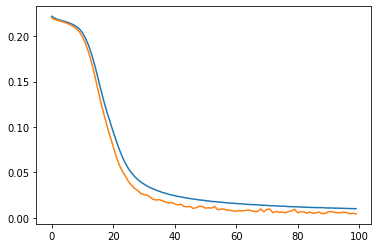

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);

## Conclusion
The above architecture is able to learn from heuristics in a supervised fashion. It learns to allocate a given budget to the asset with the largest gain in the given period. Note, of course, that this setup is unrealistic in many ways. It's just about the convergence of the setup. 